In [1]:
import pandas as pd
import tensorflow as tf

In [2]:
# setting the global seed to ensure having reproducible results
tf.random.set_seed(42)

## Reading the data from CSV files

In [3]:
train_df = pd.read_csv('Emoji Data/train.csv')

In [4]:
test_df = pd.read_csv('Emoji Data/test.csv')

In [5]:
train_df.head()

,text,emotion,emoji
0,i didnt feel humiliated,sadness,😢
1,i can go from feeling so hopeless to so damned...,sadness,😢
2,im grabbing a minute to post i feel greedy wrong,anger,😡
3,i am ever feeling nostalgic about the fireplac...,love,😍
4,i am feeling grouchy,anger,😡


In [6]:
# setting the variables according to the requirements
vocabulary_size = 10000
maximum_sequence_length = 64

##Preprocessing the data

### Splitting the data of the training and testing into inputs and targets

In [7]:
train_text = train_df.text
train_emoji = train_df.emoji

In [8]:
test_text = test_df.text
test_emoji = test_df.emoji

#### Train and test text preprocessing

In [9]:
# using this variable with the tokenizer 
training_and_testing_text_data = pd.concat([train_text,test_text])

In [10]:
# Tokenizer vectorize text by turning each text into a sequence of integers
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(training_and_testing_text_data) # tokenize the texts

In [11]:
# transform each text to a sequence of numbers
train_text_sequences = tokenizer.texts_to_sequences(train_text)
test_text_sequences = tokenizer.texts_to_sequences(test_text)

In [12]:
total_number_of_words = len(tokenizer.word_index)+1

In [13]:
# apply padding to the data
# 'pad_sequences' transforms list of sequences into a 2D numpy arrays of shape (num_samples, maxlen)
# where maxlen is the length of longest sequence, can be provided as an argument
train_text_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_text_sequences, maxlen=maximum_sequence_length , padding='post')
test_text_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(test_text_sequences, maxlen=maximum_sequence_length , padding='post')

#### Train and test emoji/labels preprocessing

In [14]:
def create_dictionary(column):
  column_unique_values= column.unique()
  column_dictionary={}
  rev_column_dictionary={}
  for index,element in enumerate(column_unique_values):
    column_dictionary[element]= index
    rev_column_dictionary[index]= element
  return column_dictionary, rev_column_dictionary

In [15]:
emoji_dictionary, reversed_emoji_dictionary = create_dictionary(train_emoji)

In [16]:
# Replacing non-numeric values with numeric values
train_emoji.replace(emoji_dictionary, inplace=True)
test_emoji.replace(emoji_dictionary, inplace=True)

In [17]:
# One Hot encodeing the targets/outputs to get a better prediction
train_emoji= tf.one_hot(train_emoji, depth=len(set(train_emoji)))
test_emoji = tf.one_hot(test_emoji, depth=len(set(test_emoji)))

In [18]:
number_of_classes = len(emoji_dictionary)

### Implementing 'tf.data' API pipelines

In [19]:
def dataset_creator(x,y):
  data = tf.data.Dataset.from_tensor_slices((x,y))
  data = data.shuffle(16000)
  data = data.batch(64)
  data = data.prefetch(tf.data.experimental.AUTOTUNE)
  return data

In [20]:
train_dataset = dataset_creator(train_text_sequences_padded,train_emoji)
test_dataset = dataset_creator(test_text_sequences_padded, test_emoji)

## LSTM Model buliding

In [155]:
# to restart tensorflow state
del tf
import tensorflow as tf
tf.random.set_seed(42)

In [156]:
model = tf.keras.Sequential ([
                              tf.keras.layers.Input([64]), # according to the maximum_sequence_length
                              tf.keras.layers.Embedding(total_number_of_words,64 ), # Embeddings are used mainly for text processing
                              tf.keras.layers.LSTM(256, return_sequences=True), # Long short-term memory
                              tf.keras.layers.Dropout(0.5), # using regularization technique to avoid overfitting
                              tf.keras.layers.LSTM(64),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(number_of_classes, activation=tf.nn.softmax) #output layer
])

In [157]:
model.compile(optimizer='Adam', loss= tf.losses.CategoricalCrossentropy(), metrics=['acc'])

In [158]:
# using ModelCheckpoint callback to save the model at the epoch with the best validation accuracy
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('Zahra_D.h5', monitor='val_acc', save_best_only=True)

In [159]:
model.fit(train_dataset,validation_data=test_dataset,epochs=35, callbacks=[model_checkpoint])

Epoch 1/35
250/250 [==============================] - 19s 63ms/step - loss: 1.6083 - acc: 0.3221 - val_loss: 1.5658 - val_acc: 0.3475
Epoch 2/35
250/250 [==============================] - 15s 60ms/step - loss: 1.5883 - acc: 0.3304 - val_loss: 1.5596 - val_acc: 0.3475
Epoch 3/35
250/250 [==============================] - 15s 60ms/step - loss: 1.5845 - acc: 0.3264 - val_loss: 1.5604 - val_acc: 0.3475
Epoch 4/35
250/250 [==============================] - 15s 60ms/step - loss: 1.5873 - acc: 0.3201 - val_loss: 1.5599 - val_acc: 0.3475
Epoch 5/35
250/250 [==============================] - 15s 60ms/step - loss: 1.5816 - acc: 0.3368 - val_loss: 1.5609 - val_acc: 0.3475
Epoch 6/35
250/250 [==============================] - 15s 60ms/step - loss: 1.5732 - acc: 0.3290 - val_loss: 1.5595 - val_acc: 0.3475
Epoch 7/35
250/250 [==============================] - 15s 60ms/step - loss: 1.5764 - acc: 0.3323 - val_loss: 1.5588 - val_acc: 0.3475
Epoch 8/35
250/250 [==============================] - 15s 60ms

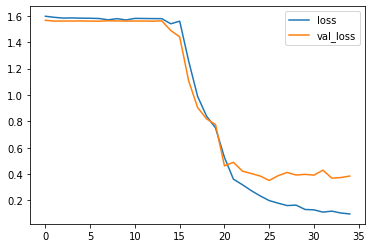

In [160]:
# Visualizing the 'loss' and 'val_loss' to display the model preformance during the fitting process
DNN_fit_history = pd.DataFrame(model.history.history)
DNN_fit_history[['loss', 'val_loss']].plot.line()

## Test & Results

Importing the model with the best validation accuracy

In [21]:
best_model = tf.keras.models.load_model('Zahra_D.h5')

In [22]:
def emoji_list():
  li = []
  for key in reversed_emoji_dictionary:
    value = reversed_emoji_dictionary[key]
    li.append(value)
  return li

In [23]:
def prediction(data):
  tokenized_data = tokenizer.texts_to_sequences([data])
  text_data_padded = tf.keras.preprocessing.sequence.pad_sequences(tokenized_data, maxlen=maximum_sequence_length, padding='post')
  pred = best_model.predict(text_data_padded)
  emoji = emoji_list()
  # taking the index of the highest prediction and taking the corresponding emoji
  print(emoji[tf.argmax(pred[0]) ])


taking an input string using Colab Forms


In [24]:
input_text = "We had such a lovely dinner tonight" #@param {type:"string"}


In [25]:
prediction(input_text)

😄
